## Automate: create, detect, write high_res blend 
started: Aug 18th 2020 <br>
edit: Sep 3 2020

In [1]:
from __future__ import print_function
import argparse
import os
import random
from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import numpy as np

import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import ndimage
from PIL import Image
from photutils import create_matching_kernel
from skimage.transform import downscale_local_mean
from astropy.convolution import convolve

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F


from astropy.convolution import convolve

from skimage.feature import blob_dog, blob_log, blob_doh

from peak_finding import (
    PeakFinder,
    find_peaks,
)

import cv2

device = torch.device("cpu")

batchSize = 64          # input batch size
imageSize = 64           # the height / width of the input image to network
ngf = 64
ndf = 64
nz = 1000
ngpu = 0    #number of GPUs to use
netG = ''
manualSeed = random.randint(1, 10000)

torch.manual_seed(manualSeed)
device = torch.device("cpu")

nc = 1

class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(1, ngf * 4, 7, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.ConvTranspose2d( ngf*4, ngf * 2, 6, 3, 2,dilation=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, nc, 3, 2, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1

netS = Shoobygen(ngpu).to(device)
netS.load_state_dict(torch.load('netG_epoch_599.pth',map_location='cpu'))

%matplotlib inline

def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)#'/Users/shemmati/Desktop/GOODS/goodsn_all_wfc3_ir_f160w_060mas_v1.0_drz.fits')#
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    return im

def brightest_center(im, r = 20):
    
    '''This function is to check whether the central object of the 
    image is the brightest compared to its neighbors in the given cutout.
    Central is defined with a 10x10 pixel square in the center'''
    
    a0,a1 = np.unravel_index(np.argmax(im, axis=None), im.shape)
    ans = False
    if ((a0>((im.shape[0]-r)/2)) & (a0<((im.shape[0]+r)/2)) & (a1>((im.shape[1]-r)/2)) & (a1<((im.shape[0]+r)/2))):
        ans = True
    
    return ans

def go_lowres(galax,out_size=21, noise_sigma=2):
    '''This function is to take high resolution galaxy cutout and go to 
    a lower pixelscale, resolution and more noise'''
    
    psf = pyfits.getdata('../psfs/psf_i.fits')
    psf = downscale_local_mean(psf,(3,3))
    psf = psf[7:-8,7:-8]
    psf_hsc = pyfits.getdata('../psfs/PSF_subaru_i.fits')
    psf_hsc = psf_hsc[1:42,1:42]
    kern = create_matching_kernel(psf,psf_hsc)

    im = galax+np.random.normal(0,noise_sigma,galax.shape)
    img = convolve(im,kern)
    outp = np.array(Image.fromarray(img).resize((out_size,out_size)))

    return outp

def make_large(lowres):
    
    np.shape(lowres)

def go_lowres_tens(galax):
    device = torch.device("cpu")
    tfms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
    im = tfms(galax)
    gals = np.repeat(im[:,:,:,np.newaxis],1,axis = 3)
    gals =torch.tensor(gals, device="cpu").float()
    gals = gals.permute(3,0,1,2)
    inputs = gals
    real_cpu = inputs.to(device)

    psf = pyfits.getdata('../psfs/psf_i.fits')
    psf = downscale_local_mean(psf,(3,3))
    psf = psf[7:-8,7:-8]#[22:-22,22:-22]
    psf_hsc = pyfits.getdata('../psfs/PSF_subaru_i.fits')
    psf_hsc = psf_hsc[1:42,1:42]
    kern = create_matching_kernel(psf,psf_hsc)
    psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
    psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
    kernel = torch.Tensor(psfh)
    kernel = kernel.permute(2,3,0,1)
    kernel =  kernel.float()
    kernel = kernel.to(device)

    im = real_cpu+0.25*torch.rand_like(real_cpu)
    downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
    img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
    return img[:,:,:,:]
 

In [2]:
def str2coord(string):
    x,y=[],[]
    if len(string)>8:
        d = string.split('[')
        d = ''.join(d)
        d2 = d.split(']')
        d2 = ''.join(d2)
        d3 = d2.split(',')
        for i in range(np.int(len(d3)/2)):
            x.append(np.int(d3[i]))
            y.append(np.int(d3[np.int(len(d3)/2)+i]))
    return x,y

def MatchGan(x,y,x2,y2):
    num=0
    if len(x2)>0:
        for i in range(len(x)):
            dis = distance(x2,np.repeat(y[i],len(x2)),y2,np.repeat(x[i],len(y2))) #distance of all Ganres to initial sources
            if np.min(dis)<5:
                num+=1
    num = min(num,len(x2))
    return num

def MatchLow(x,y,x2,y2):
    num=0
    if len(x2)>0:
        xlo = np.array(x2)*3.0
        ylo = np.array(y2)*3.0
        for i in range(len(x)):
            dis = distance(xlo,np.repeat(y[i],len(xlo)),ylo,np.repeat(x[i],len(ylo))) #distance of all Ganres to initial sources
            if np.min(dis)<10:
                num+=1
            dis = []
    num = min(num,len(x2))
    return num

def distance(x1,x2,y1,y2):
    return (np.sqrt((x1-x2)**2+(y1-y2)**2))

def magdis(f1,f2):
    r =np.ones_like(f1)
    sel1 = (f1>f2)
    r[sel1] = f1[sel1]/f2[sel1]
    sel2 = (f2>=f1)
    r[sel2]=f2[sel2]/f1[sel2]
    return r 

In [5]:
def galblend(gals=1, lim_hmag=24, plot_it=True):
    
    '''This is to put together two candels GOODS_S galaxies into a single 64x64 cutout.
    I make sure in each cutout the central galaxy is brightest object in the cutout so 
    in rescaling and adding two components still show up. Also, one galaxy is put at 
    the center and the second in some random distance from it. both cutouts are rotated with
    a random angle. Cutouts are from HST H band for now.'''
    
    ## reading GOODS-S catalog and initial selection on objects
    gs = pyfits.getdata('../../../WFIRST_WPS/CANDELS_fits/gds.fits')
    sel1 = (gs['zbest']>0.1)&(gs['zbest']<5.0)&(gs['CLASS_STAR']<0.95)&(gs['Hmag']<lim_hmag)&(gs['FWHM_IMAGE']>2)&(gs['FWHM_IMAGE']<10) &(gs['DECdeg']>-27.8)
    
   
    ra, dec,red,iflux,fwhm = gs['RA_1'][sel1],gs['DEC_1'][sel1],gs['zbest'][sel1],gs['ACS_F775W_FLUX'][sel1],gs['FWHM_IMAGE'][sel1]
    z2,flux2,x2,y2 = np.zeros(gals),np.zeros(gals),np.zeros(gals),np.zeros(gals)
    s2 = np.zeros(gals)

    im = np.zeros([64,64])
   
    data1 = np.zeros([80,80])
    da1 = np.zeros([64,64])
    while not(brightest_center(data1)):
        n = np.int(np.random.uniform(0,len(ra)-1))
        data1 = cut(ra[n],dec[n],40,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
        z2[0] = red[n]
        flux2[0] = iflux[n] 
        s2[0] = fwhm[n]
    
    angle = np.random.uniform(0,180)
    s = ndimage.rotate(data1,angle,mode='nearest',reshape=False)
    da1 = s[8:-8,8:-8]
    y2[0],x2[0] = np.unravel_index(da1.argmax(), da1.shape)
    im += da1
    
    da2 = np.zeros([gals,64,64])
    
    for boz in range(gals-1):
        #data2 = np.zeros([100,100])
        data2 = np.zeros([140,140])
        
        while not(brightest_center(data2)):
            n = np.int(np.random.uniform(0,len(ra)-1))
            #data2 = cut(ra[n],dec[n],50,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
            data2 = cut(ra[n],dec[n],70,'/Users/shemmati/Desktop/GOODS/goodss_all_acs_wfc_f775w_060mas_v1.5_drz.fits')
            
            z2[boz+1],flux2[boz+1],s2[boz+1] = red[n],iflux[n],fwhm[n]
        #p,t = np.int(np.random.uniform(5,10)),np.int(np.random.uniform(5,10))
        p,t = np.int(np.random.randint(0,15)),np.int(np.random.randint(0,15))
        #s = data2[10+t:-10+t,10+p:-10+p]
        s = data2[30+t:-30+t,30+p:-30+p]
        
        angle = np.random.uniform(0,180)
        so = ndimage.rotate(s,angle,mode='nearest',reshape=False)
        da2[boz] = so[8:-8,8:-8]
        y2[boz+1],x2[boz+1] = np.unravel_index(da2[boz].argmax(), da2[boz].shape)
        im += da2[boz]
    
        
    dada = np.arcsinh(im)
    rescaled = (255.0 / (dada.max()+0.05) * (dada - dada.min())).astype(np.uint8)
    final_im = Image.fromarray(rescaled)
        
     #### Detect sources on high res blend sample
    
    psf = pyfits.getdata('../psfs/psf_i.fits')
    num = find_peaks(image=rescaled-np.mean(rescaled), kernel = psf,thresh=np.mean(rescaled))
    x_esh,y_esh = [],[]
    for boz in range(len(num)):
        if (1<num[boz][0]<64)&(1<num[boz][1]<64):
            x_esh.append(num[boz][0])
            y_esh.append(num[boz][1])
    
    #blobs_log = blob_log(rescaled-np.mean(rescaled), min_sigma=0.1, max_sigma=5, num_sigma=20, threshold=np.mean(rescaled), overlap=0.75, log_scale=True, exclude_border=False)
    #blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2) # Compute radii in the 3rd column.
    #x_esh,y_esh = [],[]
    #for blob in blobs_log:
    #    x, y, r = blob
    #    if ((r>1)&(10<x<50)&(10<y<50)):
    #        y_esh.append(y)
    #        x_esh.append(x)
      
    ### Reduce resolution and pixel scale to Subaru and add some noise
    lowres = go_lowres(rescaled)
    
    psflo = pyfits.getdata('../psfs/PSF_subaru_i.fits')
    num = find_peaks(image=lowres, kernel = psflo,thresh=np.mean(lowres)/5.0)
    x_esh_low,y_esh_low = [],[]
    for boz in range(len(num)):
        if (1<num[boz][0]<21)&(1<num[boz][1]<21):
            x_esh_low.append(num[boz][0])
            y_esh_low.append(num[boz][1])
    ### Detect sources on Lowres
    #blobs_log = blob_log(lowres-np.mean(lowres), min_sigma= 0.1, max_sigma=5, num_sigma=2, threshold=30, overlap=0.75, log_scale=True, exclude_border=False)    
    #x_esh_low,y_esh_low = [],[]
    #for blob in blobs_log:
    #    x, y, r = blob
    #    if ((r>0.)&(4<x<16)&(4<y<16)):
    #        y_esh_low.append(y)
    #        x_esh_low.append(x)

    #### Increase resolution with the trained GAN       
    lowres_tensor = go_lowres_tens(rescaled)       
    fake = netS(lowres_tensor)
    fd = fake.detach()
    fd = fd.cpu()
    GANres = fd[0,0,:,:].numpy()
    
    ### Detect sources on GANres
    num = find_peaks(image=GANres-np.mean(GANres), kernel = psf,thresh=0.2)#np.mean(GANres))
    x_esh_fd,y_esh_fd = [],[]
    for boz in range(len(num)):
        if (1<num[boz][0]<64)&(1<num[boz][1]<64):
            x_esh_fd.append(num[boz][0])
            y_esh_fd.append(num[boz][1])
    #blobs_log = blob_log(GANres-np.mean(GANres), min_sigma=0.1, max_sigma=5, num_sigma=20, threshold=0.1, overlap=0.75, log_scale=True, exclude_border=False)
    #x_esh_fd,y_esh_fd = [],[]
    #for blob in blobs_log:
    #    x, y, r = blob
    #    if ((r>1)&(10<x<50)&(10<y<50)):
    #        y_esh_fd.append(y)
    #        x_esh_fd.append(x)

    
    if plot_it:
        plt.figure(figsize=(12,4))
        n = gals+1
        
        plt.subplot(1,n+2,1)
        plt.imshow(da1,origin='lower')
        plt.scatter(x2[0],y2[0],marker='x',color='r')
        plt.text(2,55,'z='+str(z2[0]),color='y',fontsize=20)
        plt.axis('off')

        for boz in range(gals-1):
            plt.subplot(1,n+2,2+boz)
            plt.imshow(da2[boz],origin='lower')
            plt.text(2,55,' z='+str(z2[boz+1]),color='y',fontsize=20)
            plt.scatter(x2[boz+1],y2[boz+1],marker='x',color='r')
            plt.axis('off')

        plt.subplot(1,n+2,n)
        plt.imshow(dada,origin='lower')
        plt.text(2,55,'Sum',color='y',fontsize=20)
        plt.plot(y_esh,x_esh,'ro')
        plt.axis('off')

        plt.subplot(1,n+2,n+1)
        plt.imshow(lowres,origin='lower')
        plt.text(1.5,18,'Lowres',color='y',fontsize=20)
        plt.plot(y_esh_low,x_esh_low,'ro')
        plt.axis('off')

        plt.subplot(1,n+2,n+2)
        plt.imshow(fd[0,0,:,:],origin='lower')
        plt.text(2,55,'GAN res',color='y',fontsize=20)
        plt.plot(y_esh_fd,x_esh_fd,'ro')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        
    return final_im,rescaled,[x2,y2,z2,flux2,s2,[[x_esh,y_esh],[x_esh_low,y_esh_low],[x_esh_fd,y_esh_fd]]]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


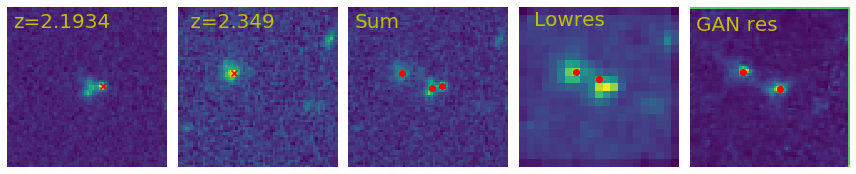

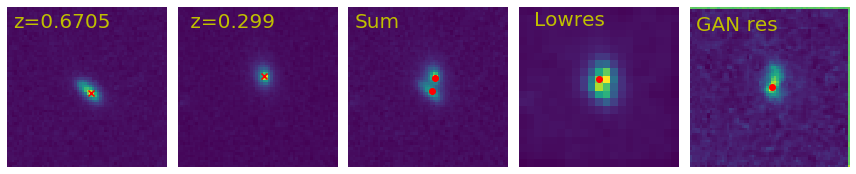

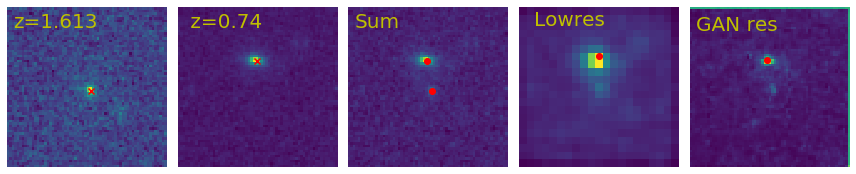

In [7]:
a,galax,data = galblend(gals=2,lim_hmag=24,plot_it=True)
a,galax,data = galblend(gals=2,lim_hmag=24,plot_it=True)
a,galax,data = galblend(gals=2,lim_hmag=24,plot_it=True)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


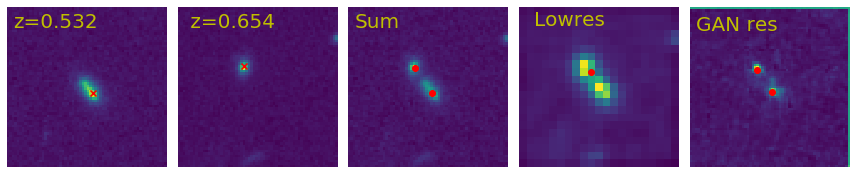

[0.8160882305241266, array(1.71633711), 0.122, 9.04, 2, 1, 2]


In [8]:
a,galax,data = galblend(gals=2,lim_hmag=25,plot_it=True)

x_low,y_low = str2coord(str(data[5][1]))
x_gan,y_gan = str2coord(str(data[5][2]))
x_hi,y_hi = str2coord(str(data[5][0]))
x,y = [data[0][0],data[0][1]],[data[1][0],data[1][1]]
numgan = MatchGan(x,y,x_gan,y_gan)
numhi = MatchGan(x,y,x_hi,y_hi)
numlow = MatchLow(x,y,x_low,y_low)
dis = 0.06*distance (data[0][0],data[0][1],data[1][0],data[1][1])
mag = magdis(data[3][0],data[3][1])
dz = np.abs(data[2][0]-data[2][1])
s = max(data[4][0],data[4][1])
print([dis,mag,dz,s,numhi,numlow,numgan])     



In [744]:
f = open('blend_data.txt','w+')
for i in range(5000):
    a,galax,data = galblend(gals=2,lim_hmag=24,plot_it=False)
    f.write(str(data[0][0])+'\t'+str(data[0][1])+'\t'+str(data[1][0])+'\t'+str(data[1][1])+'\t'+str(data[2][0])
            +'\t'+str(data[2][1])+'\t'+str(data[3][0])+'\t'+str(data[3][1])
            +'\t'+str(data[4][0])+'\t'+str(data[4][1])+'\t'+str(data[5][0])+'\t'+str(data[5][1])
            +'\t'+str(data[5][2])+'\n')
f.close()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [745]:
import pandas as pd
data = pd.read_csv('blend_data.txt', sep="\t", header=None)
data.columns = ["x1","x2", "y1","y2", "z1","z2", "flux1","flux2","s1","s2","coord_hi","coord_low","coord_gan"]

data2=[]
for boz in range(len(data['x1'])):
    x_low,y_low = str2coord(data['coord_low'][boz])
    x_gan,y_gan = str2coord(data['coord_gan'][boz])
    x_hi,y_hi = str2coord(data['coord_hi'][boz])
    x,y = [data['x1'][boz],data['x2'][boz]],[data['y1'][boz],data['y2'][boz]]
    numgan = MatchGan(x,y,x_gan,y_gan)
    numhi = MatchGan(x,y,x_hi,y_hi)
    numlow = MatchLow(x,y,x_low,y_low)
    dis = 0.06*distance (data['x1'][boz],data['x2'][boz],data['y1'][boz],data['y2'][boz])
    mag = magdis(data['flux1'][boz],data['flux2'][boz])
    dz = np.abs(data['z1'][boz]-data['z2'][boz])
    if (0<data['flux1'][boz]<100)&(0<data['flux2'][boz]<100):
        data2.append([dis,data['flux1'][boz],data['flux2'][boz],data['z1'][boz],data['z2'][boz],data['s1'][boz],data['s2'][boz],numhi,numlow,numgan])                                 

df = pd.DataFrame(data2)
df.columns = ["distance", "flux1", "flux2", "z1", "z2", "s1", "s2","numhi" ,"numlow","numgan"]


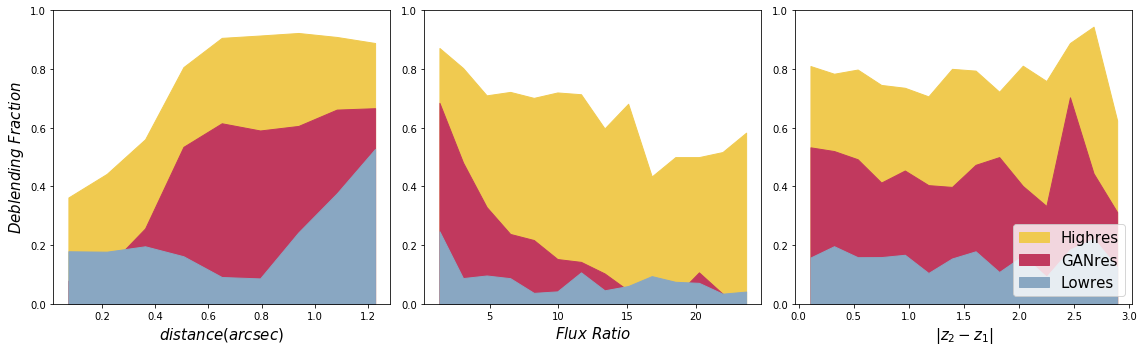

In [754]:
plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
bins = np.linspace(0, 1.3, 10)
digitized = np.digitize(df['distance'], bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum(df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_gan = [np.sum(df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
plt.xlabel(r'$distance (arcsec)$',fontsize=15)
plt.ylabel(r'$ Deblending\ Fraction$',fontsize=15)
plt.ylim([0,1])

plt.subplot(1,3,2)
bins = np.linspace(1, 25, 15)
fmax = np.maximum(np.array(df['flux1']),np.array(df['flux2']))
fmin = np.minimum(np.array(df['flux1']),np.array(df['flux2']))
flux_ratio=fmax/fmin
digitized = np.digitize(flux_ratio, bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum((df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2)) for i in range(1, len(bins))]
bin_means_gan = [np.sum((df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2)) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
plt.xlabel(r'$Flux\  Ratio$',fontsize=15)
plt.ylim([0,1])

plt.subplot(1,3,3)
bins = np.linspace(0., 3, 15)
dz = np.abs(df['z1']-df['z2'])
digitized = np.digitize(dz, bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum(df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_gan = [np.sum(df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
plt.legend(fontsize=15,loc=4)
plt.ylim([0,1])
plt.xlabel(r'$|z_{2}-z_{1}|$',fontsize=15)

plt.tight_layout()

plt.savefig('deblend_gan.png')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in long_scalars
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


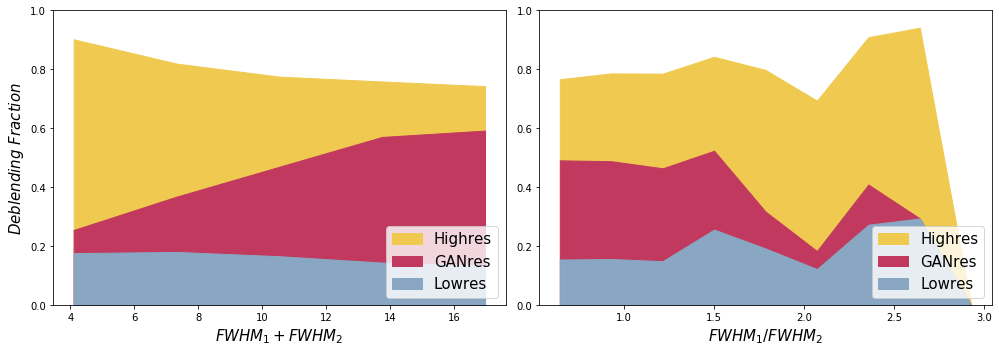

In [747]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
bins = np.linspace(5, 50, 15)
sumsize = (df['s1']+df['s2'])
digitized = np.digitize(sumsize, bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum(df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_gan = [np.sum(df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
plt.legend(fontsize=15,loc=4)
plt.xlabel(r'$FWHM_{1}+FWHM_{2}$',fontsize=15)
plt.ylabel(r'$ Deblending\ Fraction$',fontsize=15)
plt.ylim([0,1])

plt.subplot(1,2,2)
bins = np.linspace(1, 5, 15)
smax = np.maximum(np.array(df['s1']),np.array(df['s2']))
smin = np.minimum(np.array(df['s1']),np.array(df['s2']))
ds=smax/smin
digitized = np.digitize(ds, bins)
bin_means_hi = [np.sum(df[digitized == i]['numhi']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_low = [np.sum(df[digitized == i]['numlow']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
bin_means_gan = [np.sum(df[digitized == i]['numgan']==2)/np.sum(df[digitized==i]['numlow']<=2) for i in range(1, len(bins))]
x = bins[1:]-bins[1]/2
plt.fill_between(x,0,bin_means_hi,label='Highres',color='#F0CA50')
plt.fill_between(x,0,bin_means_gan,label='GANres',color='#C1395E')
plt.fill_between(x,0,bin_means_low,label='Lowres',color='#89A7C2')
plt.legend(fontsize=15,loc=4)
plt.ylim([0,1])
plt.xlabel(r'$FWHM_{1}/FWHM_{2}$',fontsize=15)

plt.tight_layout()

In [748]:
import sompy

sel = flux_ratio<30

dat=np.array([df['distance'][sel],flux_ratio[sel],sumsize[sel],dz[sel]])
#dat=np.array([df['distance'][sel],df['flux1'][sel],df['flux2'][sel],df['s1'][sel],df['s2'][sel],df['z1'][sel],df['z2'][sel]])

data=dat.T
## Training a SOM with PCA initalization
msz0 = 32
msz1 = 24
sm = sompy.SOMFactory.build(data, mapsize=[msz0,msz1], mapshape='planar', lattice='rect', initialization='pca') 
sm.train(n_job=4, shared_memory = 'no')

 Training...
 pca_linear_initialization took: 0.017000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 5

 epoch: 1 ---> elapsed time:  0.123000, quantization error: 1.264072

 epoch: 2 ---> elapsed time:  0.115000, quantization error: 1.131561

 epoch: 3 ---> elapsed time:  0.116000, quantization error: 0.911816

 epoch: 4 ---> elapsed time:  0.117000, quantization error: 0.740090

 epoch: 5 ---> elapsed time:  0.116000, quantization error: 0.625746

 Finetune training...
 radius_ini: 1.000000 , radius_final: 1.000000, trainlen: 7

 epoch: 1 ---> elapsed time:  0.113000, quantization error: 0.508983

 epoch: 2 ---> elapsed time:  0.116000, quantization error: 0.467583

 epoch: 3 ---> elapsed time:  0.119000, quantization error: 0.455222

 epoch: 4 ---> elapsed time:  0.119000, quantization error: 0.448623

 epoch: 5 ---> elapsed time:  0.114000, quantization error: 0.445333

 epoch: 6 ---> elapsed time:  0.116000, quantization error: 0.442854

 epo

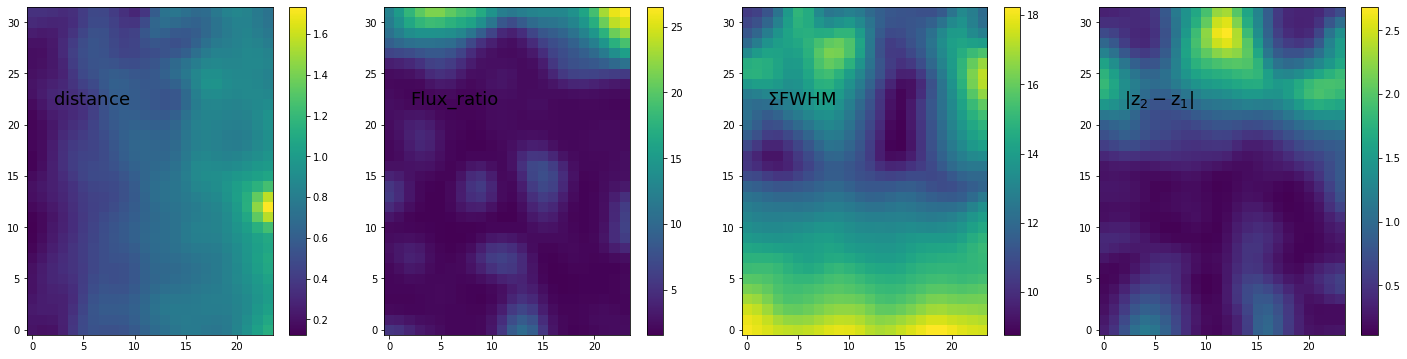

In [749]:
somcol=np.zeros(4,object)
plt.figure(figsize=(20,5))
colors=[r'$\rm distance$','Flux_ratio',r'$\rm \Sigma FWHM$',r'$\rm |z_{2}-z_{1}|$']

codebook = sm._normalizer.denormalize_by(sm.data_raw,sm.codebook.matrix)    
for ind in range(0,4):
    mp = codebook[:, ind].reshape(sm.codebook.mapsize[0],sm.codebook.mapsize[1])
    plt.subplot(1,4,ind+1)
    ax = plt.gca()
    im=ax.imshow(mp,origin='lower')
    somcol[ind]=np.ndarray.flatten(mp)
    #ax.axis('off')
    plt.text(2,msz0-10,str(colors[ind]),size=18)
    plt.colorbar(im)


plt.tight_layout()


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


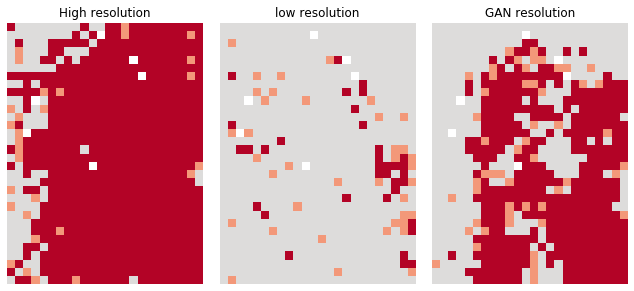

In [750]:
a=sm.bmu_ind_to_xy(sm.project_data(data))
x,y=np.zeros(len(a)),np.zeros(len(a))
k=0
for i in a:
    x[k]=i[0]
    y[k]=i[1]
    k+=1
    
med_l=np.zeros([msz0,msz1])
med_g=np.zeros([msz0,msz1])
med_h=np.zeros([msz0,msz1])

low = df['numlow'][sel]
gan = df['numgan'][sel]
hi = df['numhi'][sel]
for i in range(msz0):
    for j in range(msz1):
        unja=(x==i)&(y==j)
        med_l[i,j]=(np.median(low[unja]))
        med_g[i,j]=(np.median(gan[unja]))
        med_h[i,j]=(np.median(hi[unja]))
        

plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
plt.imshow(med_h,vmin=0,vmax=2,origin='lower',cmap='coolwarm')
plt.title('High resolution')
plt.axis('off')

plt.subplot(1,3,2)
plt.title('low resolution')
plt.imshow(med_l,vmin=0,vmax=2,origin='lower',cmap='coolwarm')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('GAN resolution')
plt.imshow(med_g,vmin=0,vmax=2,origin='lower',cmap='coolwarm')
plt.axis('off')
plt.tight_layout()